<a href="https://colab.research.google.com/github/Nyamu007/POTHOLE-DETECTION/blob/main/%F0%9F%9A%A7_YOLO_NAS_Pothole_Detection_%F0%9F%91%B7%F0%9F%8F%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'annotated-potholes-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F531821%2F973710%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240612%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240612T160108Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D25a6ecc86e4b3cbbba368c2d930d9d42ec2e2f2e35da245946f8a7a176b0c2e0466a46cff650f136af065fa6140b7331fc16187b766fd26147aeb16c27659fc73bf7e22623f7fa60bbfa027d245d49b8e2de15b02431b6d16df5b8ab907125f10a0ca56b67efc80e615ce1a72c426f01d12106e1bbc1c4dbbfd43e6b00228bbe3759ef1641f9448dae17e3f7fac5b023fbe4e0eea565221e922cfad7c63173a640f49001d24eb9873d05749cfc3350647cdd665d2cda64b29b2835af9bffa2ac335fd27736dd40f4609f98438b76f30da9ca6b4a6fea0b4672bb8701f54f13afb8657ef5d5eb8491b97c27dd8a1212e1826928669fd5977c88ac2246540370af'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 48139872 bytes downloaded
Downloaded and uncompressed: annotated-potholes-dataset
Data source import complete.


<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/docs/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

## 👋🏽 What's up! It's [Harpreet](https://twitter.com/DataScienceHarp)

I'll be guiding you through this notebook. At any point, if you get stuck or have questions, there are three ways to get in touch:

1) Send me an email with your issue: harpreet.sahota@deci.ai

2) Hop into the [Deep Learning Daily (powered by Deci) Discord server](https://discord.gg/p9ecgRhDR8), and let me know what your question is.

3) [Open an issue on GitHub](https://github.com/Deci-AI/super-gradients/issues/new/choose)


Let's get to it...

🚨 Note: after installation is complete (it make take a few minutes), you'll need to restart the runtime after installation completes.

This is a known [issue](https://github.com/obss/sahi/discussions/781) that is on our roadmap.

# 🦸🏾‍♂️ SuperGradients

SuperGradients is a PyTorch based training library.

It provides a uniform interface for the most common computer vision use cases:

- Classification

- Detection

- Segmentation

- Pose estimation

There are nearly 40 pretrained models in our model zoo. You can see the pretrained models available to you by following [this link](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/model_zoo.md).

This notebook will focus on using SuperGradients with YOLO-NAS. If you're interested in seeing how SG is used for image classification, you can check out [this templated notebook](https://colab.research.google.com/drive/1JYyEnEh2VdmKLxd7idUfBt6vLGOZxGIp?usp=sharing) that will make it easy to get started.

# 👩🏿‍🔧 Installations

Note: after installation is complete (it make take a few minutes), you'll need to restart the runtime after installation completes.

This is a known [issue](https://github.com/obss/sahi/discussions/781) that is on our roadmap.

In [2]:
%%capture
!pip install super-gradients==3.1.1

# 🏗️ Imports

In [3]:
!pip install super-gradients


In [4]:
import json
import os
import shutil
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import Union, Dict

import requests
import torch
from PIL import Image
from sklearn.model_selection import train_test_split

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

The console stream is logged into /root/sg_logs/console.log


[2024-06-12 16:18:27] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-06-12 16:18:42] INFO - utils.py - NumExpr defaulting to 2 threads.


# 🛠️ Utility functions



In [5]:
def split_dataset_on_json(json_file_path: Union[str, Path], images_dir_path: Union[str, Path]) -> None:
    """
    Split the dataset into train and test sets based on the contents of a JSON file.

    The function expects a JSON file that contains two keys: 'train' and 'test'.
    The values associated with these keys are lists of file names (without extensions).
    The function will create 'train' and 'test' directories and copy the corresponding
    '.xml' and '.jpg' files for each file listed in the JSON file.

    Parameters
    ----------
    json_file_path : Union[str, Path]
        The file path to the JSON file that defines the train and test sets.
    images_dir_path : Union[str, Path]
        The path to the directory containing the annotated images (.xml and .jpg files).

    Returns
    -------
    None
    """
    # Convert input paths to pathlib.Path objects
    json_file_path = Path(json_file_path)
    images_dir_path = Path(images_dir_path)
    train_dir_path = Path('train')
    test_dir_path = Path('test')

    # Load JSON file into a Python dictionary
    with json_file_path.open('r') as file:
        data_dict = json.load(file)

    # Extract file lists for train and test sets
    train_files = data_dict['train']
    test_files = data_dict['test']

    # Create train and test directories if they don't exist
    train_dir_path.mkdir(parents=True, exist_ok=True)
    test_dir_path.mkdir(parents=True, exist_ok=True)

    # Copy .xml and .jpg files for the train set
    for file_name in train_files:
        # Remove .xml extension from file name if present
        file_name = file_name.replace('.xml', '')
        # Construct file paths for .xml and .jpg files
        xml_file_path = images_dir_path / (file_name + '.xml')
        jpg_file_path = images_dir_path / (file_name + '.jpg')

        # Copy .xml and .jpg files to the train directory
        shutil.copy(xml_file_path, train_dir_path)
        shutil.copy(jpg_file_path, train_dir_path)

    # Copy .xml and .jpg files for the test set
    for file_name in test_files:
        # Remove .xml extension from file name if present
        file_name = file_name.replace('.xml', '')
        # Construct file paths for .xml and .jpg files
        xml_file_path = images_dir_path / (file_name + '.xml')
        jpg_file_path = images_dir_path / (file_name + '.jpg')

        # Copy .xml and .jpg files to the test directory
        shutil.copy(xml_file_path, test_dir_path)
        shutil.copy(jpg_file_path, test_dir_path)

    print('Files have been successfully copied to the train and test directories.')


def split_directory(train_dir: Union[str, Path], split_ratio: float = 0.2, random_state: int = None) -> None:
    """
    Splits a directory containing images and XML files into training and validation sets.

    :param train_dir: The input directory containing images and XML files.
    :type train_dir: Union[str, Path]
    :param split_ratio: The ratio of validation files to the total number of files. Default is 0.2.
    :type split_ratio: float
    :param random_state: Random state to ensure reproducibility. Default is None.
    :type random_state: int
    """
    # Step 1: List all image and XML files in the train directory
    train_dir = Path(train_dir)
    image_files = list(train_dir.glob('*.jpg'))  # Assuming images are in JPG format
    xml_files = list(train_dir.glob('*.xml'))

    # Step 2: Extract stem of each file and group image and XML files sharing the same stem
    stems = set()
    for image_file in image_files:
        stems.add(image_file.stem)

    # Step 3: Split the list of stems into two groups: train and val
    train_stems, val_stems = train_test_split(list(stems), test_size=split_ratio, random_state=random_state)

    # Step 4: Create train and val directories if they don't already exist
    val_dir = train_dir.parent / 'val'
    val_dir.mkdir(exist_ok=True)

    # Step 5: Move corresponding image and XML files to appropriate directories based on split
    for stem in val_stems:
        image_file = train_dir / f"{stem}.jpg"  # Assuming images are in JPG format
        xml_file = train_dir / f"{stem}.xml"

        if image_file.exists() and xml_file.exists():
            # Move image and XML files to val directory
            shutil.move(str(image_file), str(val_dir / image_file.name))
            shutil.move(str(xml_file), str(val_dir / xml_file.name))

    # Count the number of files moved to the "val" directory
    num_moved_files = len(val_stems) * 2  # Each stem corresponds to an image and an XML file
    # Print the completion message
    print(f"Task complete! {num_moved_files} files have been moved to the 'val' directory.")
    print(f"Training files are located in: {train_dir}")
    print(f"Validation files are located in: {val_dir}")


def convert_xml_to_yolo(xml_folder: Union[str, Path], output_folder: Union[str, Path], class_mapping: Dict[str, int]) -> None:
    """
    Convert XML annotations to YOLO format.

    Parameters:
    - xml_folder (Union[str, Path]): Path to the folder containing the XML annotation files.
    - output_folder (Union[str, Path]): Path to the folder where the YOLO annotation files will be saved.
    - class_mapping (Dict[str, int]): Dictionary mapping class names to integer class indices.

    Returns:
    None
    """
    # Convert the input folders to Path objects
    xml_folder = Path(xml_folder)
    output_folder = Path(output_folder)

    # Create the output folder if it does not exist
    output_folder.mkdir(parents=True, exist_ok=True)

    # Iterate through the files in the xml_folder
    for xml_file in xml_folder.glob("*.xml"):
        # Parse the XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Get the image size
        size = root.find("size")
        img_width = int(size.find("width").text)
        img_height = int(size.find("height").text)

        # Create a new text file for the YOLO annotations
        yolo_filename = xml_file.with_suffix(".txt").name
        yolo_file_path = output_folder / yolo_filename
        with open(yolo_file_path, "w") as yolo_file:
            for obj in root.iter("object"):
                # Get the class name and index
                class_name = obj.find("name").text
                class_index = class_mapping[class_name]

                # Get the bounding box coordinates
                box = obj.find("bndbox")
                xmin = int(box.find("xmin").text)
                ymin = int(box.find("ymin").text)
                xmax = int(box.find("xmax").text)
                ymax = int(box.find("ymax").text)

                # Calculate the YOLO-format coordinates and dimensions
                x_center = (xmin + xmax) / 2 / img_width
                y_center = (ymin + ymax) / 2 / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                # Write the annotation in YOLO format
                yolo_file.write(f"{class_index} {x_center} {y_center} {width} {height}\n")

class_mapping = {
    "pothole": 0
}

In [6]:
split_dataset_on_json('../input/annotated-potholes-dataset/splits.json', '../input/annotated-potholes-dataset/annotated-images')

split_directory('train', split_ratio=0.2, random_state=42)

convert_xml_to_yolo(xml_folder="./train",
                    output_folder="./train",
                    class_mapping=class_mapping)


convert_xml_to_yolo(xml_folder="./val",
                    output_folder="./val",
                    class_mapping=class_mapping)

convert_xml_to_yolo(xml_folder="./test",
                    output_folder="./test",
                    class_mapping=class_mapping)

# 🗃️ Config

This class will store variables that will be used throughout the notebook

In [7]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'path/to/checkpoint/dir' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'pothole-detection' #specify the experiment name

    #dataset params
    DATA_DIR = '.' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'train' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'val' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'val' #child dir of DATA_DIR where validation labels are

    # if you have a test set
    TEST_IMAGES_DIR = 'test' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test' #child dir of DATA_DIR where test labels are

    CLASSES = ['pothole'] #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

# 🪡 Fine-tuning YOLONAS on custom dataset

## 🏋🏽 The trainer

The first thing you need to define in SuperGradients is the Trainer.

The trainer is in charge of training, evaluation, saving checkpoints, etc. If you're interested in seeing the source code for the trainer, you can do so [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/sg_trainer/sg_trainer.py).

### ✌🏼 There's two important arguments to the trainer:

1) `ckpt_root_dir` - this is the directory where results from all your experiments will be saved

2)`experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

SuperGradients supports **Data Parallel** and **Distributed Data Parallel**.

That's outside of the scope for this introduction to SuperGradients. But, if you're fortunate enough to have multiple GPUs at your disposal or want learn more you can do so [here](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/device.md#3-dp---data-parallel).

In the code below, you'll instantiate the trainer with just a single GPU (since that's what Google Colab provides)

In [8]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# 💾 Datasets and DataLoaders

SuperGradients is fully compatible with PyTorch Datasets and Dataloaders, so you can use your dataloaders as is.

There are several well-known datasets for object detection, for example:

- COCO
- Pascal
- YOLODarkNet
- YOLOv5

SuperGradients provides ready-to-use dataloaders for these datasets. If you're interested in learning more about working with `COCOFormatDetectionDataset` and the more general `DetectionDataset` [check out the SuperGradients documentation on this topic](https://docs.deci.ai/super-gradients/docstring/training/datasets/#training.datasets.detection_datasets.coco_detection.COCODetectionDataset)

You can learn more about working with SuperGradients datasets, dataloaders, and configuration files [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Data.md)

SuperGradients supports a number of dataset formats, you can learn more about that [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ObjectDetection.md)


In [9]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Files have been successfully copied to the train and test directories.
Task complete! 214 files have been moved to the 'val' directory.
Training files are located in: train
Validation files are located in: val


[2024-06-12 16:18:45] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 425/425 [00:00<00:00, 5573.63it/s]
[2024-06-12 16:18:45] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 107/107 [00:00<00:00, 3374.31it/s]
[2024-06-12 16:18:45] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


## 👀 See what some images look like after augmentations

SuperGradients added `transforms` for you. You're free to experiment with these transformations as you please. You can also add in your own transformations from `torchvision.transforms`, `albumentations` or a custom tranformaton.

Indexing dataset annotations: 100%|██████████| 133/133 [00:00<00:00, 5890.19it/s]


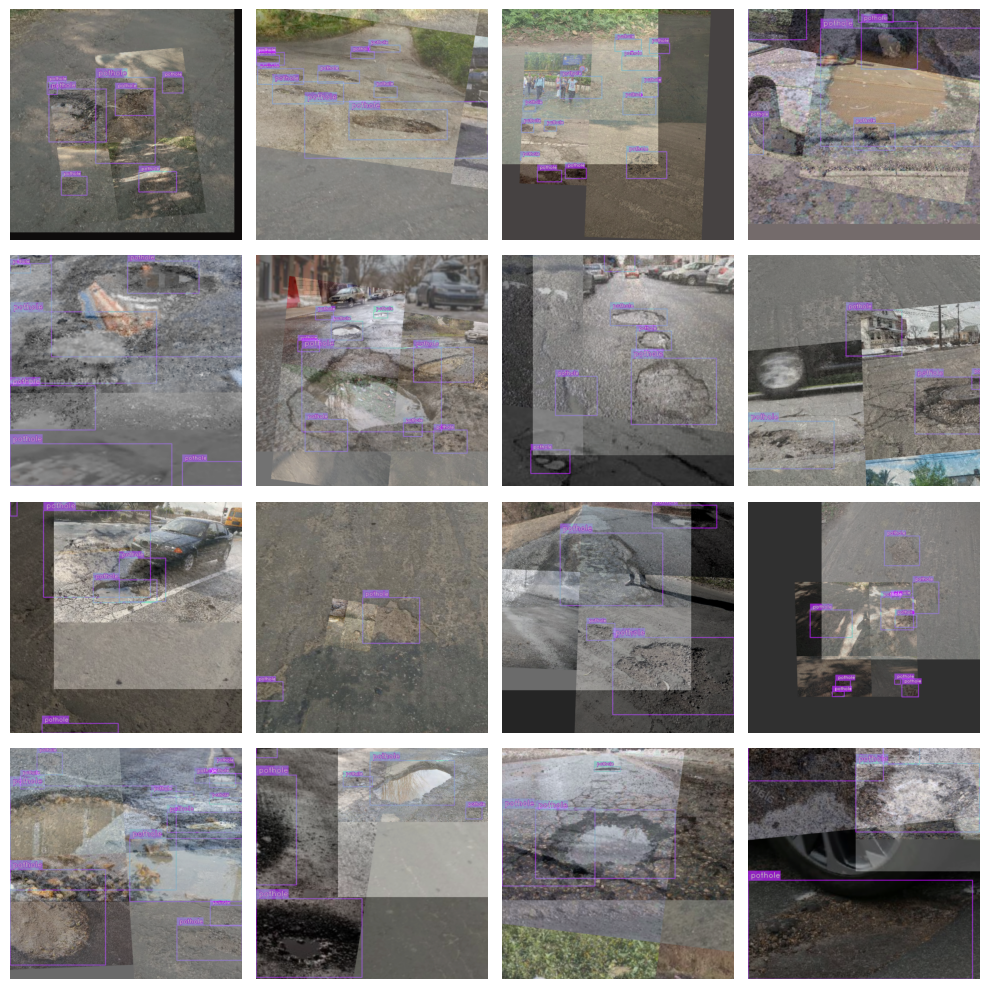

In [10]:
train_data.dataset.plot()

# 👩🏽‍🦳 Instantiate the model

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [11]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2024-06-12 16:18:57] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-06-12 16:18:57] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:01<00:00, 173MB/s]
[2024-06-12 16:19:00] INFO - checkpoint

# 📊 Define metrics and training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.


### 🧑🏾‍🔬 Integrations with experiment monitoring tools

SuperGradients has native integrations with Tensorboard, Weights and Biases, and ClearML.

If your favorite monitoring tool is not supported by SuperGradients, you can simply implement a class inheriting from BaseSGLogger that you will then pass to the training parameters.

If you're interested in monitoring experiments, you can learn more [in the docs](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/experiment_monitoring.md).


### 🪄 SuperGradients offers a number of training tricks right out of the box, such as:

- Exponential moving average
- Zero weight decay on bias and batch normalizatiom
- Weight averaging
- Batch accumulation
- Precise BatchNorm

You can read more details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).

If you're interested in building a using a custom metric with SuperGradients you can learn how [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Metrics.md).

Note you will have to set number of classes in two places below: `PPYoloELoss` and `DetectionMetrics_050`.

You probably noticed that we make use of a post prediction callback, for details on how phase callbacks work in SuperGradients [check out our documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/PhaseCallbacks.md).

### 🔕 Note: I've enabled `silent_mode` so the notebook doesn't get longer than it already is. You should disable it so you can see what SuperGradients outputs during training.

In [12]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 🦾 Train the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as..

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-06-12 16:45:27] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240612_164527_755935`
[2024-06-12 16:45:27] INFO - sg_trainer.py - Checkpoints directory: path/to/checkpoint/dir/pothole-detection/RUN_20240612_164527_755935
[2024-06-12 16:45:27] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to path/to/checkpoint/dir/pothole-detection/RUN_20240612_164527_755935/console_Jun12_16_45_27.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid

# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_best.pth)`

- last weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_latest.pth)`

In [14]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

[2024-06-12 16:33:00] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileNotFoundError: Incorrect Checkpoint path: path/to/checkpoint/dir/pothole-detection/average_model.pth (This should be an absolute path)

In [16]:
import os

# Construct the checkpoint path
checkpoint_dir = os.path.abspath(config.CHECKPOINT_DIR)
experiment_name = config.EXPERIMENT_NAME
checkpoint_filename = 'average_model.pth'
checkpoint_path = os.path.join(checkpoint_dir, experiment_name, checkpoint_filename)

# Print the checkpoint path to verify it
print(f"Checkpoint path: {checkpoint_path}")

# Check if the checkpoint file exists
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint file not found at: {checkpoint_path}")

# Load the model if the file exists
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=checkpoint_path)


FileNotFoundError: Checkpoint file not found at: /content/path/to/checkpoint/dir/pothole-detection/average_model.pth

Checkpoint path: /content/path/to/checkpoint/dir/pothole-detection/average_model.pth


# 🧐 Evaluating the best trained model on the test set

In [17]:
trainer.test(model=best_model,
            test_loader=test_loader,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,                                                                              nms_threshold=0.7)
                                                  ))

NameError: name 'best_model' is not defined

# 🔮 Predicting with the best model

You can make a prediction by calling the `.predict()` method of the model object.

Note, you can set the confidence threshold value as you please.


In [15]:
url = 'https://i.cbc.ca/1.2568081.1394547708!/fileImage/httpImage/pothole.jpg'
best_model.predict(url,  conf=0.25).show()

NameError: name 'best_model' is not defined